In [1]:
%cd ../..

/Users/davideleo/Desktop/Projects/research/papers/fl_wavelet_v0


# Malicious detector 
## Wavelet Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78612876..1.708492].


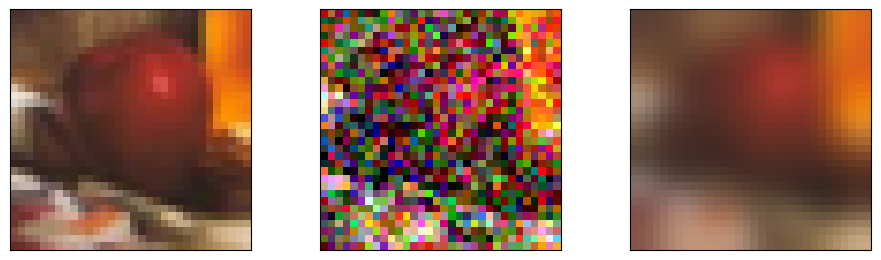

In [2]:
import random 
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from kymatio.torch import Scattering2D
from src.data.cifar100 import get_federation
from src.data.attacks import GaussianBlur, GaussianNoise 
from src.domains.detection import train_detector
from sklearn.decomposition import PCA

random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

# Load a sample image 
dataset = get_federation(num_shards = 1, alpha = 1000)[0]
dataset["test"].load()
x, _ = dataset["test"][0]
dataset["test"].clear()

# Attacks
gnoise = GaussianNoise(sigma = .5)
gblur = GaussianBlur(kernel_size = 11)

x_noise = gnoise(x)
x_blur = gblur(x)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 4))
ax0, ax1, ax2 = axs.flatten()

ax0.imshow(torch.swapaxes(torch.swapaxes((x + 1) / 2, 0, 1), 1, 2))
ax0.set_xticks([]); ax0.set_xticklabels([])
ax0.set_yticks([]); ax0.set_yticklabels([])

ax1.imshow(torch.swapaxes(torch.swapaxes((x_noise + 1) / 2, 0, 1), 1, 2))
ax1.set_xticks([]); ax0.set_xticklabels([])
ax1.set_yticks([]); ax0.set_yticklabels([])

ax2.imshow(torch.swapaxes(torch.swapaxes((x_blur + 1) / 2, 0, 1), 1, 2))
ax2.set_xticks([]); ax0.set_xticklabels([])
ax2.set_yticks([]); ax0.set_yticklabels([])

plt.tight_layout(pad = 5.)
plt.show()

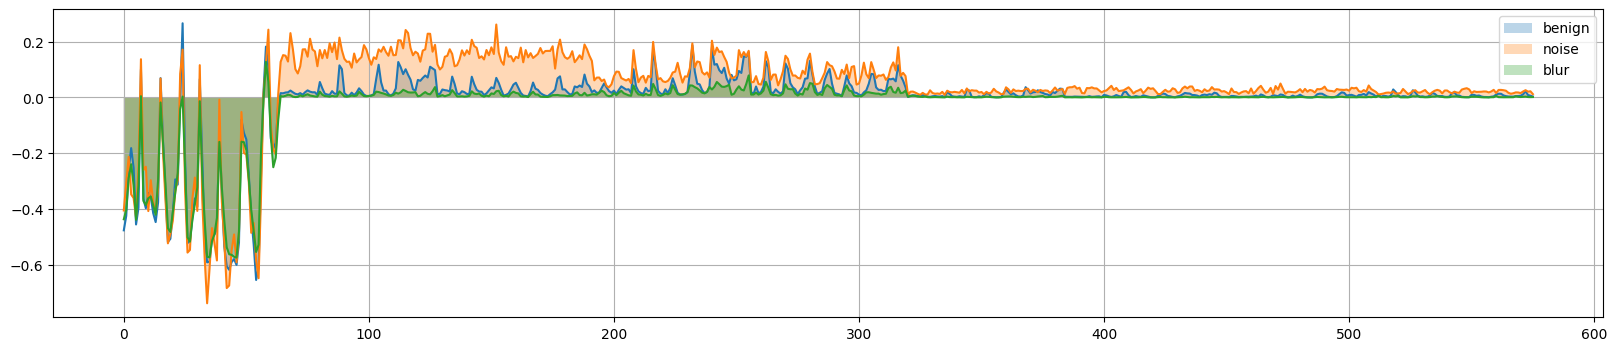

In [3]:
# WST domain extraction 
def wst_domain(
        x: torch.Tensor, 
        J_wst: int = 2,
        L_wst: int = 4
) -> torch.Tensor: 
    # Setup
    x = 0.2989 * x[0] + 0.5870 * x[1] + 0.1140 * x[2] 
    x = x.view(1, 32, 32)
    _, h, w = x.size()
    wst = Scattering2D(J = J_wst, shape = (h, w), L = L_wst)
    x_wst = wst(x).reshape(-1)
    return x_wst

x_benign_fft = wst_domain(x, J_wst = 2, L_wst = 2)
x_noise_fft = wst_domain(x_noise, J_wst = 2, L_wst = 2)
x_blur_fft = wst_domain(x_blur, J_wst = 2, L_wst = 2)


plt.figure(figsize = (20, 4))
plt.plot(torch.arange(x_benign_fft.size(0)), x_benign_fft)
plt.plot(torch.arange(x_noise_fft.size(0)), x_noise_fft)
plt.plot(torch.arange(x_blur_fft.size(0)), x_blur_fft)
plt.fill_between(torch.arange(x_benign_fft.size(0)), 0., x_benign_fft, alpha = .3, label = "benign")
plt.fill_between(torch.arange(x_noise_fft.size(0)), 0., x_noise_fft, alpha = .3, label = "noise")
plt.fill_between(torch.arange(x_blur_fft.size(0)), 0., x_blur_fft, alpha = .3, label = "blur")
plt.legend()
plt.grid()
plt.show()

## Clusters visualization 

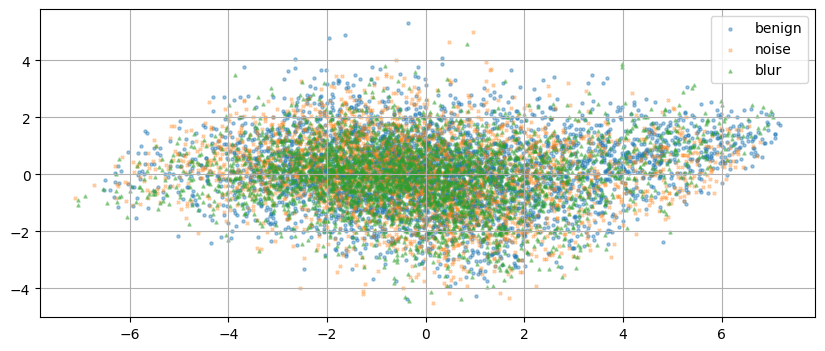

In [4]:
# Dataset 
dataset["test"].load()
X = torch.stack([x for x, _ in dataset["test"].cache])
dataset["test"].clear()

X[4000:7000] = gnoise(X[4000:7000])
X[7000:] = gblur(X[7000:]) 
X = 0.2989 * X[:, 0] + 0.5870 * X[:, 1] + 0.1140 * X[:, 2] 

labels = np.zeros(10000, dtype = int)
labels[4000:7000] = 1 
labels[7000:] = 2

# WST domains
J_wst = 2
L_wst = 2
num_samples, height, width = X.size()
wst = Scattering2D(J = J_wst, shape = (height, width), L = L_wst)
X_wst = wst(X).reshape(num_samples, -1)

pca = PCA(n_components = 2, random_state = 42).fit(X_wst)
X_wst_pca = pca.transform(X_wst)

plt.figure(figsize = (10, 4))
plt.scatter(X_wst_pca[labels == 0, 0], X_wst_pca[labels == 0, 1], marker = "o", s = 5, alpha = .4, label = "benign")
plt.scatter(X_wst_pca[labels == 1, 0], X_wst_pca[labels == 1, 1], marker = "x", s = 5, alpha = .4, label = "noise")
plt.scatter(X_wst_pca[labels == 2, 0], X_wst_pca[labels == 2, 1], marker = "^", s = 5, alpha = .4, label = "blur")
plt.grid()
plt.legend()
plt.show()

# Detector training

In [5]:
# Train detector
dataset = get_federation(num_shards = 1, alpha = 1000)[0]

# This is not the model we are going to use for real experiments, 
# this is just a demo
model = train_detector(
    train_dataset = dataset["train"],
    test_dataset = dataset["test"],
    discriminant = "wst",
    discriminant_params = {"J_wst": 2, "L_wst": 2},
    num_epochs = 10, 
    batch_size = 64,
    pca_n_components = None,
    device = "cpu"
)

  0%|          | 0/10 [00:00<?, ?it/s]

- Epoch 1: accuracy_score = 0.5455


 10%|█         | 1/10 [00:34<05:07, 34.12s/it]

- Epoch 2: accuracy_score = 0.5051


 20%|██        | 2/10 [01:08<04:33, 34.23s/it]

- Epoch 3: accuracy_score = 0.5152


 30%|███       | 3/10 [01:45<04:10, 35.73s/it]

- Epoch 4: accuracy_score = 0.7576


 40%|████      | 4/10 [02:22<03:35, 35.93s/it]

- Epoch 5: accuracy_score = 1.0


 50%|█████     | 5/10 [02:59<03:02, 36.45s/it]

- Epoch 6: accuracy_score = 1.0


 60%|██████    | 6/10 [03:36<02:26, 36.60s/it]

- Epoch 7: accuracy_score = 0.9495


 70%|███████   | 7/10 [04:12<01:49, 36.37s/it]

- Epoch 8: accuracy_score = 0.9798


 80%|████████  | 8/10 [04:48<01:12, 36.35s/it]

- Epoch 9: accuracy_score = 0.9899


100%|██████████| 10/10 [05:26<00:00, 32.70s/it]

- Epoch 10: accuracy_score = 0.9899
